In [1]:
import jax
import numpy as onp
import jax.numpy as jnp
from jax import grad
import mesh_processing as mp
import pmm

try:
    import meshplot
    meshplot_available = True
except ImportError as e:
    meshplot_available = False

import matplotlib.pyplot as plt

In [2]:
V_pc,F_pc = mp.objloader('project2/meshes/Spheroids/','partial_cubified.obj')
V_s,F_s = mp.objloader('project2/meshes/Spheroids/','Sphere.obj')
V_c,F_c = mp.objloader('project2/meshes/Spheroids/','cubified.obj')

/home/dith/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
def to_numpy_array(X):
    Np_array = onp.zeros(X.shape)
    for n in range(X.shape[0]):
        Np_array[n] = X[n]
    return Np_array

def plot_mesh(V,F):
    if meshplot_available:
        V_plot = to_numpy_array(V)
        F_plot = to_numpy_array(F)
        mplot.plot(V_plot,F_plot)
    else:
        print('Did not plot - meshplot not available')
    
plot_mesh(V_pc,F_pc)
plot_mesh(V_c,F_c)
plot_mesh(V_s,F_s)

Did not plot - meshplot not available
Did not plot - meshplot not available
Did not plot - meshplot not available


In [4]:
N_pc,A_pc = mp.compute_normals_and_areas(V_pc,F_pc)
N_s,A_s = mp.compute_normals_and_areas(V_s,F_s)
N_c,A_c = mp.compute_normals_and_areas(V_c,F_c)

In [5]:
def center_of_mass(V,F):
    return (V[F[:,0]]+V[F[:,1]]+V[F[:,2]])/3

In [6]:
def Gaussian_Kernel(sigma):
    def f(x,y):
        return jnp.exp(-jnp.linalg.norm(x-y)**2/(2*sigma**2))
    return f

def Gaussian_Kernel_Norm(sigma):
    def f(norm):
        return jnp.exp(-norm**2/(2*sigma**2))
    return f
    

#Set Kernel

def distCurves(V1,F1,V2,F2,sigma):
    N1,A1 = mp.compute_normals_and_areas(V1,F1)
    N2,A2 = mp.compute_normals_and_areas(V2,F2)
    M1 = center_of_mass(V1,F1)
    M2 = center_of_mass(V2,F2)
    #print(jnp.shape(N1))
    D = jnp.vectorize(lambda x,y: x-y)
    def term(m1,m2,n1,n2):
        Km = jnp.exp(-(D(m1[:,0].reshape(-1,1),m2[:,0].reshape(1,-1))**2+D(m1[:,1].reshape(-1,1),m2[:,1].reshape(1,-1))**2+D(m1[:,2].reshape(-1,1),m2[:,2].reshape(1,-1))**2)*1/(2*sigma**2))
        #print(jnp.shape(jnp.dot(n1, n2.T)*Km))
        return jnp.sum(jnp.dot(n1, n2.T)*Km)
    term1 = term(M1,M1,N1,N1)
    term2 = term(M2,M2,N2,N2)
    term3 = -2*term(M1,M2,N1,N2)
    res = term1 + term2 + term3
    return jnp.sqrt(res)

def final_distCurves(V1,F1,V2,F2,sigma):
    return distCurves(V1,F1,V2,F2,sigma)
    #return min(distCurves(V1,F1,V2,F2,sigma), distCurves(V1,F1,-V2,F2,sigma))

In [7]:
def scalar_dist(c,V,F):
    return final_distCurves(V,F,V+c,F,2)

print(scalar_dist(jnp.float32(1),V_s,F_s),scalar_dist(jnp.float32(-1),V_s,F_s))

863.11725 863.11725


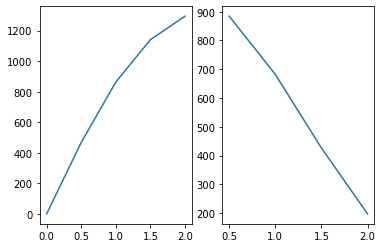

In [8]:
grad(scalar_dist)(jnp.float32(1.01),V_s,F_s)
x = onp.linspace(0,2,5)
y = [grad(scalar_dist)(jnp.float32(n),V_s,F_s) for n in x]
z = [scalar_dist(jnp.float32(n),V_s,F_s) for n in x]
plt.figure()
plt.subplot(1,2,1)
plt.plot(x,z)
plt.subplot(1,2,2)
plt.plot(x,y)
plt.show()

In [9]:
plot_mesh((-1)*V_s,F_s)

Did not plot - meshplot not available


In [10]:
print(scalar_dist(jnp.float32(1),V_s,F_s),scalar_dist(jnp.float32(-1),V_s,F_s))

863.11725 863.11725


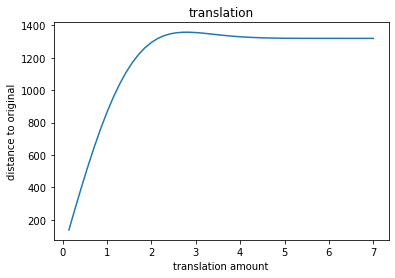

In [11]:
x = jnp.linspace(0, 7, 50)
y = pmm.translate_x(distCurves, V_s, F_s, x)
plt.title('translation')
plt.plot(x, y)
plt.xlabel('translation amount')
plt.ylabel('distance to original')
plt.show()

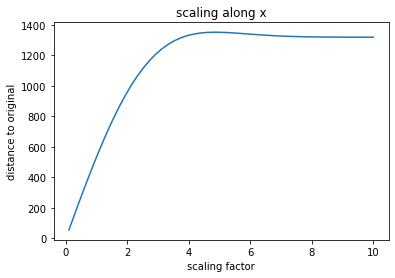

In [12]:
x = jnp.linspace(0.1, 10, 50)
y = pmm.scale_x(distCurves, V_s, F_s, x)
plt.title('scaling along x')
plt.plot(x, y)
plt.xlabel('scaling factor')
plt.ylabel('distance to original')
plt.show()

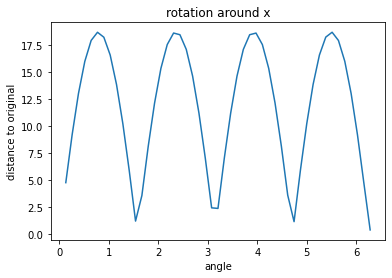

In [13]:
x = jnp.linspace(0, 2*jnp.pi, 50)
y = pmm.rotate_x(distCurves, V_s, F_s, x)
plt.title('rotation around x')
plt.plot(x, y)
plt.xlabel('angle')
plt.ylabel('distance to original')
plt.show()

In [14]:
D = jnp.vectorize(lambda x,y: x - y)
print(V_s.shape)

dists = D(V_s[:,0].reshape(-1,1), V_s[:,0].reshape(1,-1))**2 + \
        D(V_s[:,1].reshape(-1,1), V_s[:,1].reshape(1,-1))**2 + \
        D(V_s[:,2].reshape(-1,1), V_s[:,2].reshape(1,-1))**2

min_dist = jnp.sqrt(jnp.min(dists[jnp.triu(dists, 1)>0]))

print(min_dist.shape)
print('min dist:', min_dist)

(1538, 3)
()
min dist: 0.07878168


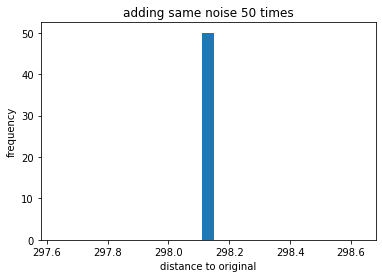

In [15]:
x = jnp.ones(50)*min_dist/2
y = pmm.add_noise(distCurves, V_s, F_s, x)
plt.title('adding same noise 50 times')
plt.hist(y,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')
plt.show()

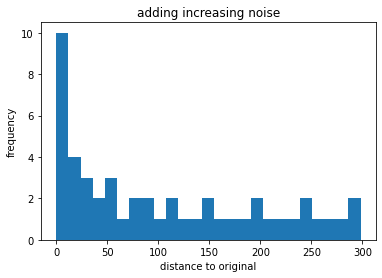

In [16]:
x = jnp.linspace(0,min_dist/2,50)
y = pmm.add_noise(distCurves, V_s, F_s, x)
plt.title('adding increasing noise')
plt.hist(y,bins=25)
plt.xlabel('distance to original')
plt.ylabel('frequency')
plt.show()